In [1]:
import os

repo_dir = "Movie-Recommender-System"

if os.path.exists(repo_dir):
    print(f"{repo_dir} already exists. Removing it...\n")
    !rm -r {repo_dir}

# Clone the repository from GitHub
!git clone https://github.com/Goshmar/Movie-Recommender-System

Cloning into 'Movie-Recommender-System'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 62 (delta 18), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (62/62), 6.77 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
import requests
import zipfile
import pandas as pd
import numpy as np

# Define the paths
zip_file_path = "/content/Movie-Recommender-System/data/raw/ml-100k.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# ZIP cleaning up
os.remove(zip_file_path)

In [3]:
!pip install surprise -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
from surprise import Dataset
from surprise.model_selection import train_test_split

# Load the MovieLens 100K dataset
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [5]:
# Load additional feature information
rating_info = pd.read_csv("/content/ml-100k/u.data",sep = '\t', names = ['user_id', 'movie_id', 'rating', 'unix_timestamp'])
user_info = pd.read_csv('/content/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
item_info = pd.read_csv('/content/ml-100k/u.item', sep='|', encoding='latin-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDB_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

In [9]:
# Convert the Surprise trainset to a DataFrame
trainset_df = pd.DataFrame(trainset.all_ratings(), columns=['user_id', 'item_id', 'rating'])

# Merge additional feature information with trainset_df
trainset_df = pd.merge(trainset_df, user_info, on='user_id')
trainset_df = pd.merge(trainset_df, item_info[['movie_id', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']], left_on='item_id', right_on='movie_id')

# Create a user-item rating matrix with additional features
rating_matrix = trainset_df.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
feature_matrix = trainset_df.pivot_table(index='user_id', values=['age', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], fill_value=0)

In [10]:
# ========== SVD Model ==========
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

# Convert 'user_id' and 'movie_id' to integers
user_ids = rating_info['user_id'].astype('int')
movie_ids = rating_info['movie_id'].astype('int')

# Create a CSR matrix
data_matrix = csr_matrix(
    (rating_info['rating'].astype('f8'), (user_ids, movie_ids)),
    shape=(user_ids.max() + 1, movie_ids.max() + 1)
)

U, S, Vt = svds(data_matrix, k=50, return_singular_vectors='vh')

In [11]:
matching_rows = item_info.loc[item_info.movie_title.str.contains('Lord', flags=2)]

# Check if there are any matching rows
matching_index = matching_rows.index[0] if not matching_rows.empty else None

print("First matching index:", matching_index)
matching_rows

First matching index: 550


,movie_id,movie_title,release_date,video_release_date,IMDB_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
550,551,Lord of Illusions (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Lord%20of%20I...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
966,967,Little Lord Fauntleroy (1936),01-Jan-1936,NaN,http://us.imdb.com/M/title-exact?Little%20Lord...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
item_info.iloc[np.argsort(-Vt.T @ Vt[:, matching_index])[1:6]][['movie_id', 'movie_title']]

,movie_id,movie_title
226,227,Star Trek VI: The Undiscovered Country (1991)
403,404,Pinocchio (1940)
161,162,On Golden Pond (1981)
385,386,Addams Family Values (1993)
568,569,Wolf (1994)


In [13]:
from scipy.sparse.linalg import spsolve_triangular

# ========== Hybrid Model ==========

# Calculate SVD for the rating matrix
u, s, vt = np.linalg.svd(rating_matrix.values, full_matrices=False)
v = vt.T[:, :50]

# Item similarity matrix
d = 0.5  # off-diagonal similarity factor
item_similarity_matrix = np.eye(feature_matrix.shape[1])
item_similarity_matrix[-1, -3] = d
item_similarity_matrix[-3, -1] = d

# Finding Cholesky factors
L = np.linalg.cholesky(item_similarity_matrix)

# Update this line to match the shape of the feature matrix
u2, s2, v2 = np.linalg.svd(np.dot(feature_matrix.values, L), full_matrices=False)
v2 = v2.T[:, :50]

# Preparing for hybrid folding-in calculation
lv = np.dot(L, v2)
rv = spsolve_triangular(csr_matrix(L.T), v2, lower=False)

# Recommendations for the user with the hybrid model
recs_hybrid = np.dot(feature_matrix.values, lv).dot(rv.T)

# Extract top N recommendations
top_n_hybrid = np.argsort(-recs_hybrid)[0][:10]

# Create a list of dictionaries for the recommendations
recommendations_data = []
for i, idx in enumerate(top_n_hybrid):
    movie_id = item_info.iloc[idx]['movie_id']
    movie_title = item_info.iloc[idx]['movie_title']
    recommendations_data.append({
        'movie_id': movie_id,
        'movie_title': movie_title
    })

# Convert the list of dictionaries to a DataFrame
recommendations_df = pd.DataFrame(recommendations_data)
recommendations_df

,movie_id,movie_title
0,19,Antonia's Line (1995)
1,8,Babe (1995)
2,5,Copycat (1995)
3,1,Toy Story (1995)
4,16,French Twist (Gazon maudit) (1995)
5,14,"Postino, Il (1994)"
6,15,Mr. Holland's Opus (1995)
7,2,GoldenEye (1995)
8,4,Get Shorty (1995)
9,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...


In [14]:
from surprise import SVD
from surprise import accuracy

# Build and train the SVD model
model_svd = SVD(n_factors=50)
model_svd.fit(trainset)

# Make predictions on the test set
predictions_svd = model_svd.test(testset)

# Calculate and print RMSE
rmse_svd = accuracy.rmse(predictions_svd)
print("SVD RMSE:", rmse_svd)

RMSE: 0.9315
SVD RMSE: 0.9315083798942929


In [ ]:
# Make predictions for the hybrid model

predictions_hybrid = recs_hybrid.flatten()

test_predictions = []
for uid, iid, true_r, est, _ in predictions_svd:
    movie_index = item_info[item_info['movie_id'] == int(iid)].index
    if not movie_index.empty and movie_index[0] in feature_matrix.index:
        pred_hybrid = predictions_hybrid[movie_index[0]]
        test_predictions.append((uid, iid, true_r, est, pred_hybrid))

# Calculate and print RMSE for the hybrid model
rmse_hybrid = accuracy.rmse(test_predictions)
print("Hybrid SVD RMSE:", rmse_hybrid)

RMSE: 0.9211
Hybrid SVD RMSE: 0.921148008261399


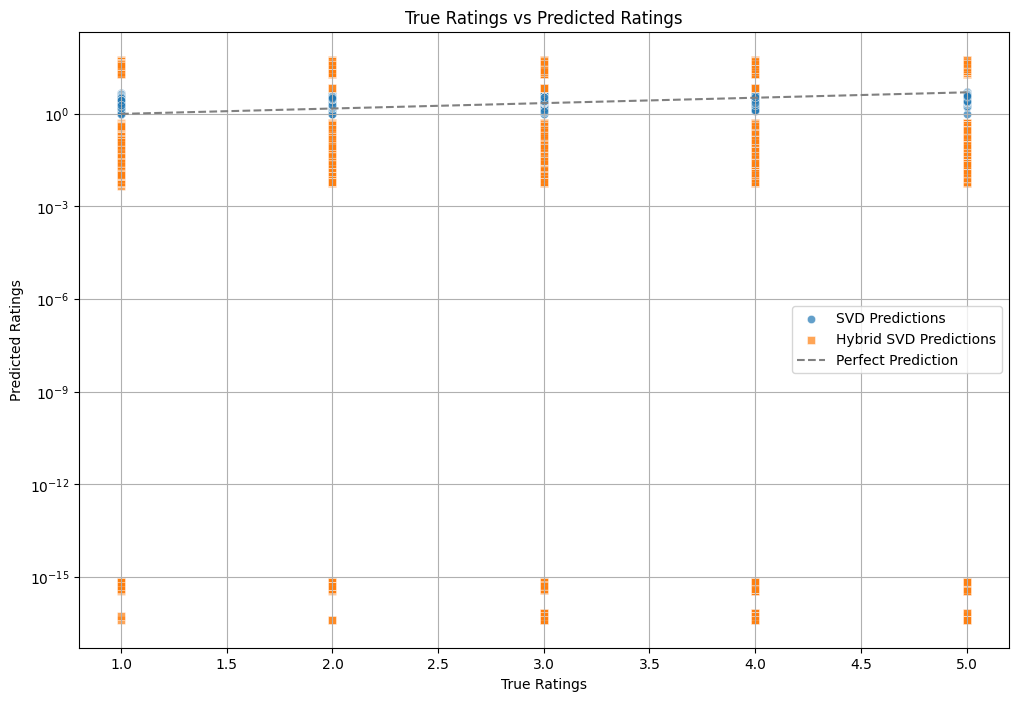

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract true ratings and estimated ratings from predictions
true_ratings = np.array([true_r for _, _, true_r, _, _ in test_predictions])
estimated_ratings_svd = np.array([est for _, _, _, est, _ in test_predictions])
estimated_ratings_hybrid = np.array([pred_hybrid for _, _, _, _, pred_hybrid in test_predictions])

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=true_ratings, y=estimated_ratings_svd, label='SVD Predictions', alpha=0.7, marker='o')
sns.scatterplot(x=true_ratings, y=estimated_ratings_hybrid, label='Hybrid SVD Predictions', alpha=0.7, marker='s')

# Plot a diagonal line representing perfect predictions
plt.plot([min(true_ratings), max(true_ratings)], [min(true_ratings), max(true_ratings)], linestyle='--', color='gray', label='Perfect Prediction')

plt.title('True Ratings vs Predicted Ratings')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()